# AI CMP5103 – Project
## Reinforcement Learning in Stochastic Gridworlds
**Student:** Seyedmobin Ghaderinasab  
**Student ID:** 2018202  

This notebook is designed to run end-to-end in **Google Colab** using **Runtime → Run all**.
It implements **Q-learning** and **SARSA**, compares them under **deterministic vs. stochastic** transitions, and performs sensitivity analysis over **α, γ, and ε-greedy schedules**.


## 0. Setup
Install requirements (Colab usually has numpy/matplotlib already).


In [1]:
!pip -q install numpy matplotlib



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import random, math, json, os
import numpy as np
import matplotlib.pyplot as plt
random.seed(0); np.random.seed(0)


## 1. Environment: Stochastic Gridworld (MDP)
States are grid cells (excluding walls). Actions are **Up/Right/Down/Left**.
Transitions can be deterministic or stochastic via a slip probability.


In [9]:

class StochasticGridworld:
    ACTIONS = ["U","R","D","L"]
    DELTAS = {"U":(-1,0), "R":(0,1), "D":(1,0), "L":(0,-1)}
    PERP = {"U":["L","R"], "D":["L","R"], "L":["U","D"], "R":["U","D"]}

    def __init__(self, nrows=6, ncols=6, start=(0,0), goal=(5,5), walls=None,
                 step_penalty=-1.0, goal_reward=20.0, slip_prob=0.2):
        self.nrows=nrows; self.ncols=ncols
        self.start=start; self.goal=goal
        self.walls=set(walls) if walls else set()
        self.step_penalty=step_penalty
        self.goal_reward=goal_reward
        self.slip_prob=slip_prob

        self.states=[]
        self.state_to_idx={}
        for r in range(nrows):
            for c in range(ncols):
                if (r,c) not in self.walls:
                    self.state_to_idx[(r,c)] = len(self.states)
                    self.states.append((r,c))
        self.terminal=set([self.goal])
        if self.goal in self.walls or self.start in self.walls:
            raise ValueError("Start/Goal cannot be walls.")

    def reset(self):
        return self.start

    def is_terminal(self, s):
        return s in self.terminal

    def in_bounds(self, rc):
        r,c=rc
        return 0<=r<self.nrows and 0<=c<self.ncols and (r,c) not in self.walls

    def step(self, s, a):
        if self.is_terminal(s):
            return s, 0.0, True

        # stochastic slip
        if random.random() < self.slip_prob:
            a2 = random.choice(self.PERP[a])
        else:
            a2 = a

        dr, dc = self.DELTAS[a2]
        sp = (s[0]+dr, s[1]+dc)
        if not self.in_bounds(sp):
            sp = s

        r = self.step_penalty
        done = False
        if sp == self.goal:
            r += self.goal_reward
            done = True
        return sp, r, done

    def render_ascii(self, policy=None):
        grid = [["." for _ in range(self.ncols)] for __ in range(self.nrows)]
        for (r,c) in self.walls:
            grid[r][c]="#"
        sr,sc=self.start; gr,gc=self.goal
        grid[sr][sc]="S"; grid[gr][gc]="G"
        if policy:
            arrows={"U":"^","R":">","D":"v","L":"<"}
            for (r,c) in self.states:
                if (r,c) in self.walls or (r,c)==self.goal or (r,c)==self.start:
                    continue
                if (r,c) in policy:
                    grid[r][c]=arrows[policy[(r,c)]]
        return "\n".join(" ".join(row) for row in grid)


In [10]:
walls={(1,1),(1,2),(2,1),(3,3),(4,1),(4,2)}
env_det = StochasticGridworld(walls=walls, slip_prob=0.0)
env_sto = StochasticGridworld(walls=walls, slip_prob=0.2)
print('Deterministic grid:')
print(env_det.render_ascii())
print('\nStochastic grid (same layout, slip_prob=0.2):')
print(env_sto.render_ascii())


Deterministic grid:
S . . . . .
. # # . . .
. # . . . .
. . . # . .
. # # . . .
. . . . . G

Stochastic grid (same layout, slip_prob=0.2):
S . . . . .
. # # . . .
. # . . . .
. . . # . .
. # # . . .
. . . . . G


## 2. RL Algorithms: Q-learning and SARSA
Both algorithms use an **ε-greedy** exploration policy.


In [11]:

def epsilon_greedy(Q, s_idx, eps):
    nA = Q.shape[1]
    if random.random() < eps:
        return random.randrange(nA)
    return int(np.argmax(Q[s_idx]))

def q_learning(env, episodes=2500, alpha=0.2, gamma=0.95,
               eps_start=1.0, eps_end=0.05, eps_decay=0.998, max_steps=250):
    nS = len(env.states); nA = len(env.ACTIONS)
    Q = np.zeros((nS,nA), dtype=float)
    returns=[]
    eps=eps_start
    for ep in range(episodes):
        s=env.reset()
        s_idx=env.state_to_idx[s]
        G=0.0
        for t in range(max_steps):
            a_idx = epsilon_greedy(Q, s_idx, eps)
            a = env.ACTIONS[a_idx]
            sp, r, done = env.step(s, a)
            sp_idx = env.state_to_idx[sp]
            td_target = r + gamma*(0.0 if done else np.max(Q[sp_idx]))
            Q[s_idx,a_idx] += alpha*(td_target - Q[s_idx,a_idx])
            s, s_idx = sp, sp_idx
            G += r
            if done:
                break
        returns.append(G)
        eps = max(eps_end, eps*eps_decay)
    return Q, np.array(returns)

def sarsa(env, episodes=2500, alpha=0.2, gamma=0.95,
          eps_start=1.0, eps_end=0.05, eps_decay=0.998, max_steps=250):
    nS = len(env.states); nA = len(env.ACTIONS)
    Q = np.zeros((nS,nA), dtype=float)
    returns=[]
    eps=eps_start
    for ep in range(episodes):
        s=env.reset()
        s_idx=env.state_to_idx[s]
        a_idx = epsilon_greedy(Q, s_idx, eps)
        G=0.0
        for t in range(max_steps):
            a = env.ACTIONS[a_idx]
            sp, r, done = env.step(s, a)
            sp_idx = env.state_to_idx[sp]
            if done:
                Q[s_idx,a_idx] += alpha*(r - Q[s_idx,a_idx])
                G += r
                break
            ap_idx = epsilon_greedy(Q, sp_idx, eps)
            td_target = r + gamma*Q[sp_idx, ap_idx]
            Q[s_idx,a_idx] += alpha*(td_target - Q[s_idx,a_idx])
            s, s_idx, a_idx = sp, sp_idx, ap_idx
            G += r
        returns.append(G)
        eps = max(eps_end, eps*eps_decay)
    return Q, np.array(returns)

def moving_average(x, w=50):
    if len(x) < w:
        return x
    return np.convolve(x, np.ones(w)/w, mode="valid")

def greedy_policy_from_Q(env, Q):
    pol = {}
    for s in env.states:
        if env.is_terminal(s) or s==env.start:
            continue
        s_idx = env.state_to_idx[s]
        pol[s] = env.ACTIONS[int(np.argmax(Q[s_idx]))]
    return pol


## 3. Core Experiment: Q-learning vs SARSA (Deterministic vs Stochastic)


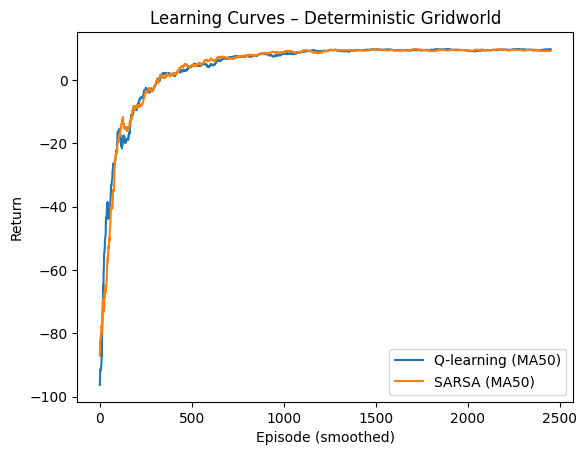

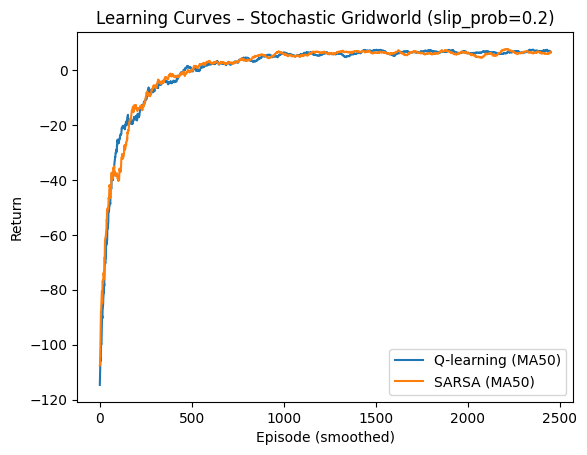

In [12]:
episodes=2500; max_steps=250
Qq_det, Rq_det = q_learning(env_det, episodes=episodes, max_steps=max_steps)
Qs_det, Rs_det = sarsa(env_det, episodes=episodes, max_steps=max_steps)
Qq_sto, Rq_sto = q_learning(env_sto, episodes=episodes, max_steps=max_steps)
Qs_sto, Rs_sto = sarsa(env_sto, episodes=episodes, max_steps=max_steps)

plt.figure()
plt.plot(moving_average(Rq_det, 50), label='Q-learning (MA50)')
plt.plot(moving_average(Rs_det, 50), label='SARSA (MA50)')
plt.xlabel('Episode (smoothed)'); plt.ylabel('Return')
plt.title('Learning Curves – Deterministic Gridworld')
plt.legend(); plt.show()

plt.figure()
plt.plot(moving_average(Rq_sto, 50), label='Q-learning (MA50)')
plt.plot(moving_average(Rs_sto, 50), label='SARSA (MA50)')
plt.xlabel('Episode (smoothed)'); plt.ylabel('Return')
plt.title('Learning Curves – Stochastic Gridworld (slip_prob=0.2)')
plt.legend(); plt.show()


### Greedy Policies (ASCII visualization)
Below we show the greedy policy derived from each learned Q-table.


In [13]:
print('Deterministic – Q-learning greedy policy:')
print(env_det.render_ascii(greedy_policy_from_Q(env_det, Qq_det)))
print('\nDeterministic – SARSA greedy policy:')
print(env_det.render_ascii(greedy_policy_from_Q(env_det, Qs_det)))
print('\nStochastic – Q-learning greedy policy:')
print(env_sto.render_ascii(greedy_policy_from_Q(env_sto, Qq_sto)))
print('\nStochastic – SARSA greedy policy:')
print(env_sto.render_ascii(greedy_policy_from_Q(env_sto, Qs_sto)))


Deterministic – Q-learning greedy policy:
S > > > v v
^ # # > > v
v # > > > v
> > ^ # > v
v # # > > v
> > > > > G

Deterministic – SARSA greedy policy:
S > > v v v
^ # # > v v
v # > > v v
v > ^ # > v
v # # > > v
> > > > > G

Stochastic – Q-learning greedy policy:
S > > > v v
v # # v > v
v # > > v v
v > ^ # v v
v # # > v v
> > > > > G

Stochastic – SARSA greedy policy:
S > > > v v
^ # # v > v
v # > > v v
v > ^ # v v
v # # > > v
> > > > > G


## 4. Sensitivity Analysis: Learning Rate α (Q-learning, Stochastic)


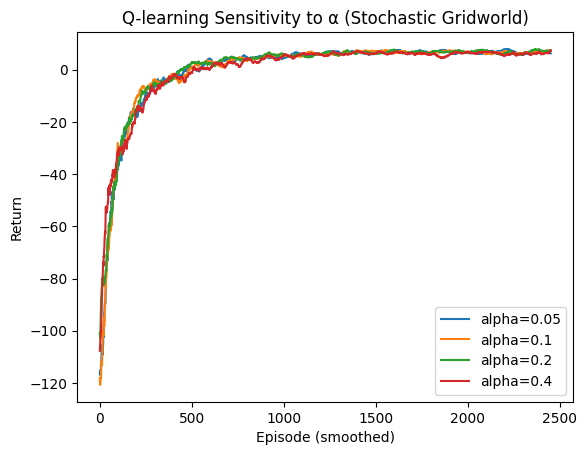

In [14]:
alphas=[0.05,0.1,0.2,0.4]
plt.figure()
for a in alphas:
    _, R = q_learning(env_sto, episodes=episodes, alpha=a, max_steps=max_steps)
    plt.plot(moving_average(R, 50), label=f'alpha={a}')
plt.xlabel('Episode (smoothed)'); plt.ylabel('Return')
plt.title('Q-learning Sensitivity to α (Stochastic Gridworld)')
plt.legend(); plt.show()


## 5. Sensitivity Analysis: Discount Factor γ (SARSA, Stochastic)


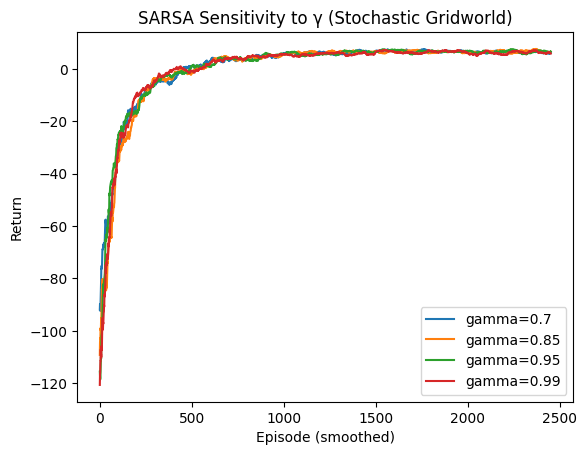

In [15]:
gammas=[0.7,0.85,0.95,0.99]
plt.figure()
for g in gammas:
    _, R = sarsa(env_sto, episodes=episodes, gamma=g, max_steps=max_steps)
    plt.plot(moving_average(R, 50), label=f'gamma={g}')
plt.xlabel('Episode (smoothed)'); plt.ylabel('Return')
plt.title('SARSA Sensitivity to γ (Stochastic Gridworld)')
plt.legend(); plt.show()


## 6. Save Results (Optional)
This cell saves plots and a small JSON summary if you run in Colab.


In [16]:

import time
out_dir = "AI_CMP5103_outputs_" + str(int(time.time()))
os.makedirs(out_dir, exist_ok=True)

summary = {
    "student_name": "Seyedmobin Ghaderinasab",
    "student_id": "2018202",
    "episodes": episodes,
    "max_steps": max_steps,
    "final_avg_return_last_200": {
        "deterministic": {
            "q_learning": float(np.mean(Rq_det[-200:])),
            "sarsa": float(np.mean(Rs_det[-200:])),
        },
        "stochastic": {
            "q_learning": float(np.mean(Rq_sto[-200:])),
            "sarsa": float(np.mean(Rs_sto[-200:])),
        }
    }
}
with open(os.path.join(out_dir, "summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("Saved to:", out_dir)


Saved to: ari5001_outputs_1769704359
